# Location Processor Test Results Analysis

This notebook analyzes GPS location data processing results, visualizing vehicle movement patterns, filtering decisions, and data quality metrics.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported successfully!")

Libraries imported successfully!


In [40]:
# Load the JSONL data
data_path = '/Users/ralf.sigmund/GitHub/location-tracker/backend/processor_test_results.jsonl'

def load_jsonl(file_path):
    """Load JSONL file into a list of dictionaries"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load the data
raw_data = load_jsonl(data_path)
print(f"Loaded {len(raw_data)} records")
print("Sample record structure:")
print(json.dumps(raw_data[0], indent=2)[:500] + '...')

Loaded 2329 records
Sample record structure:
{
  "input": {
    "lat": 41.80902,
    "time": "2025-04-22T14:41:46+02:00",
    "cog": 357.2,
    "battery": 27,
    "satellites_used": 7,
    "timestamp": 1745325706,
    "sog": 50.36,
    "quality": 6,
    "device_id": "vehicle_01",
    "lon": 2.764111,
    "cycle_time": 0,
    "ele": 65.77,
    "time_raw": [
      2025,
      4,
      22,
      14,
      41,
      46
    ]
  },
  "processed_at": "2025-05-23T16:24:56.701285",
  "processing_result": "stored",
  "stored": true,
  "reason": "Val...


In [41]:
# Extract and flatten the data for analysis
def extract_data(raw_data):
    """Extract relevant fields from the nested JSON structure"""
    records = []
    
    for record in raw_data:
        # Extract input data
        input_data = record['input']
        
        # Create a flattened record
        flat_record = {
            # Location data
            'lat': input_data.get('lat'),
            'lon': input_data.get('lon'),
            'ele': input_data.get('ele'),
            
            # Time data
            'time': input_data.get('time'),
            'timestamp': input_data.get('timestamp'),
            
            # Vehicle data
            'device_id': input_data.get('device_id'),
            'battery': input_data.get('battery'),
            'satellites_used': input_data.get('satellites_used'),
            'quality': input_data.get('quality'),
            
            # Movement data
            'cog': input_data.get('cog'),  # Course over ground
            'sog': input_data.get('sog'),  # Speed over ground
            'cycle_time': input_data.get('cycle_time'),
            
            # Processing results
            'processing_result': record.get('processing_result'),
            'stored': record.get('stored'),
            'reason': record.get('reason'),
            'distance_from_last': record.get('distance_from_last'),
            'processed_at': record.get('processed_at')
        }
        
        records.append(flat_record)
    
    return pd.DataFrame(records)

# Create DataFrame
df = extract_data(raw_data)

# Convert time columns
df['time'] = pd.to_datetime(df['time'])
df['processed_at'] = pd.to_datetime(df['processed_at'])

print(f"DataFrame shape: {df.shape}")
print("\nDataFrame info:")
print(df.info())
print("\nFirst few rows:")
df.head()

DataFrame shape: (2329, 17)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype                    
---  ------              --------------  -----                    
 0   lat                 2329 non-null   float64                  
 1   lon                 2329 non-null   float64                  
 2   ele                 2329 non-null   float64                  
 3   time                2329 non-null   datetime64[ns, UTC+02:00]
 4   timestamp           2329 non-null   int64                    
 5   device_id           2329 non-null   object                   
 6   battery             2329 non-null   int64                    
 7   satellites_used     2329 non-null   int64                    
 8   quality             2329 non-null   int64                    
 9   cog                 2329 non-null   float64                  
 10  sog                 2329 non-null   flo

,lat,lon,ele,time,timestamp,device_id,battery,satellites_used,quality,cog,sog,cycle_time,processing_result,stored,reason,distance_from_last,processed_at
0,41.80902,2.764111,65.77,2025-04-22 14:41:46+02:00,1745325706,vehicle_01,27,7,6,357.20,50.36,0,stored,True,Valid location with significant movement,NaN,2025-05-23 16:24:56.701285
1,41.81076,2.764114,24.92,2025-04-22 14:41:53+02:00,1745325713,vehicle_01,27,7,1,0.80,47.33,6,stored,True,Valid location with significant movement,193.479332,2025-05-23 16:24:56.701333
2,41.81207,2.764173,24.33,2025-04-22 14:41:59+02:00,1745325719,vehicle_01,27,7,1,1.49,47.38,6,stored,True,Valid location with significant movement,145.747404,2025-05-23 16:24:56.701368
3,41.81381,2.764269,24.71,2025-04-22 14:42:07+02:00,1745325727,vehicle_01,27,7,1,1.54,46.30,6,stored,True,Valid location with significant movement,193.642687,2025-05-23 16:24:56.701393
4,41.81509,2.764269,24.56,2025-04-22 14:42:13+02:00,1745325733,vehicle_01,27,6,1,0.06,45.81,6,stored,True,Valid location with significant movement,142.329506,2025-05-23 16:24:56.701415


In [42]:
# Basic data exploration
print("=== DATA OVERVIEW ===")
print(f"Total records: {len(df)}")
print(f"Unique devices: {df['device_id'].nunique()}")
print(f"Time range: {df['time'].min()} to {df['time'].max()}")
print(f"Duration: {df['time'].max() - df['time'].min()}")

print("\n=== PROCESSING RESULTS ===")
print(df['processing_result'].value_counts())
print(f"\nStored percentage: {df['stored'].mean():.2%}")

print("\n=== FILTERING REASONS ===")
print(df['reason'].value_counts())

print("\n=== BASIC STATISTICS ===")
df.describe()

=== DATA OVERVIEW ===
Total records: 2329
Unique devices: 1
Time range: 2025-04-22 14:41:46+02:00 to 2025-04-22 23:02:42+02:00
Duration: 0 days 08:20:56

=== PROCESSING RESULTS ===
processing_result
stored                     1705
no_significant_movement     611
outlier_filtered             13
Name: count, dtype: int64

Stored percentage: 73.21%

=== FILTERING REASONS ===
reason
Valid location with significant movement    1705
Movement less than minimum threshold         611
Location identified as outlier                13
Name: count, dtype: int64

=== BASIC STATISTICS ===


,lat,lon,ele,timestamp,battery,satellites_used,quality,cog,sog,cycle_time,distance_from_last,processed_at
count,2329.000000,2329.000000,2329.000000,2.329000e+03,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2328.000000,2329
mean,43.548262,3.868699,80.560777,1.745338e+09,87.116788,13.341778,0.998283,87.709562,41.114762,19.313010,283.615162,2025-05-23 16:24:56.721173504
min,41.809020,2.758891,-9.210000,1.745326e+09,27.000000,5.000000,0.000000,0.000000,0.010000,0.000000,0.000000,2025-05-23 16:24:56.701285
25%,42.578360,2.846965,60.970000,1.745331e+09,80.000000,12.000000,1.000000,1.250000,1.170000,10.000000,6.822645,2025-05-23 16:24:56.712088064
50%,43.348160,3.329491,83.000000,1.745337e+09,100.000000,13.000000,1.000000,35.010000,49.250000,14.000000,249.648611,2025-05-23 16:24:56.721021952
75%,44.514360,4.782068,97.070000,1.745345e+09,100.000000,15.000000,1.000000,81.200000,65.380000,20.000000,466.071554,2025-05-23 16:24:56.730727936
max,45.695750,5.912766,213.720000,1.745356e+09,100.000000,21.000000,6.000000,359.920000,77.270000,76.000000,3971.991347,2025-05-23 16:24:56.740405
std,1.190125,1.090515,30.289861,8.577825e+03,21.756820,2.790659,0.120838,123.247914,28.040983,15.546886,268.765229,NaN


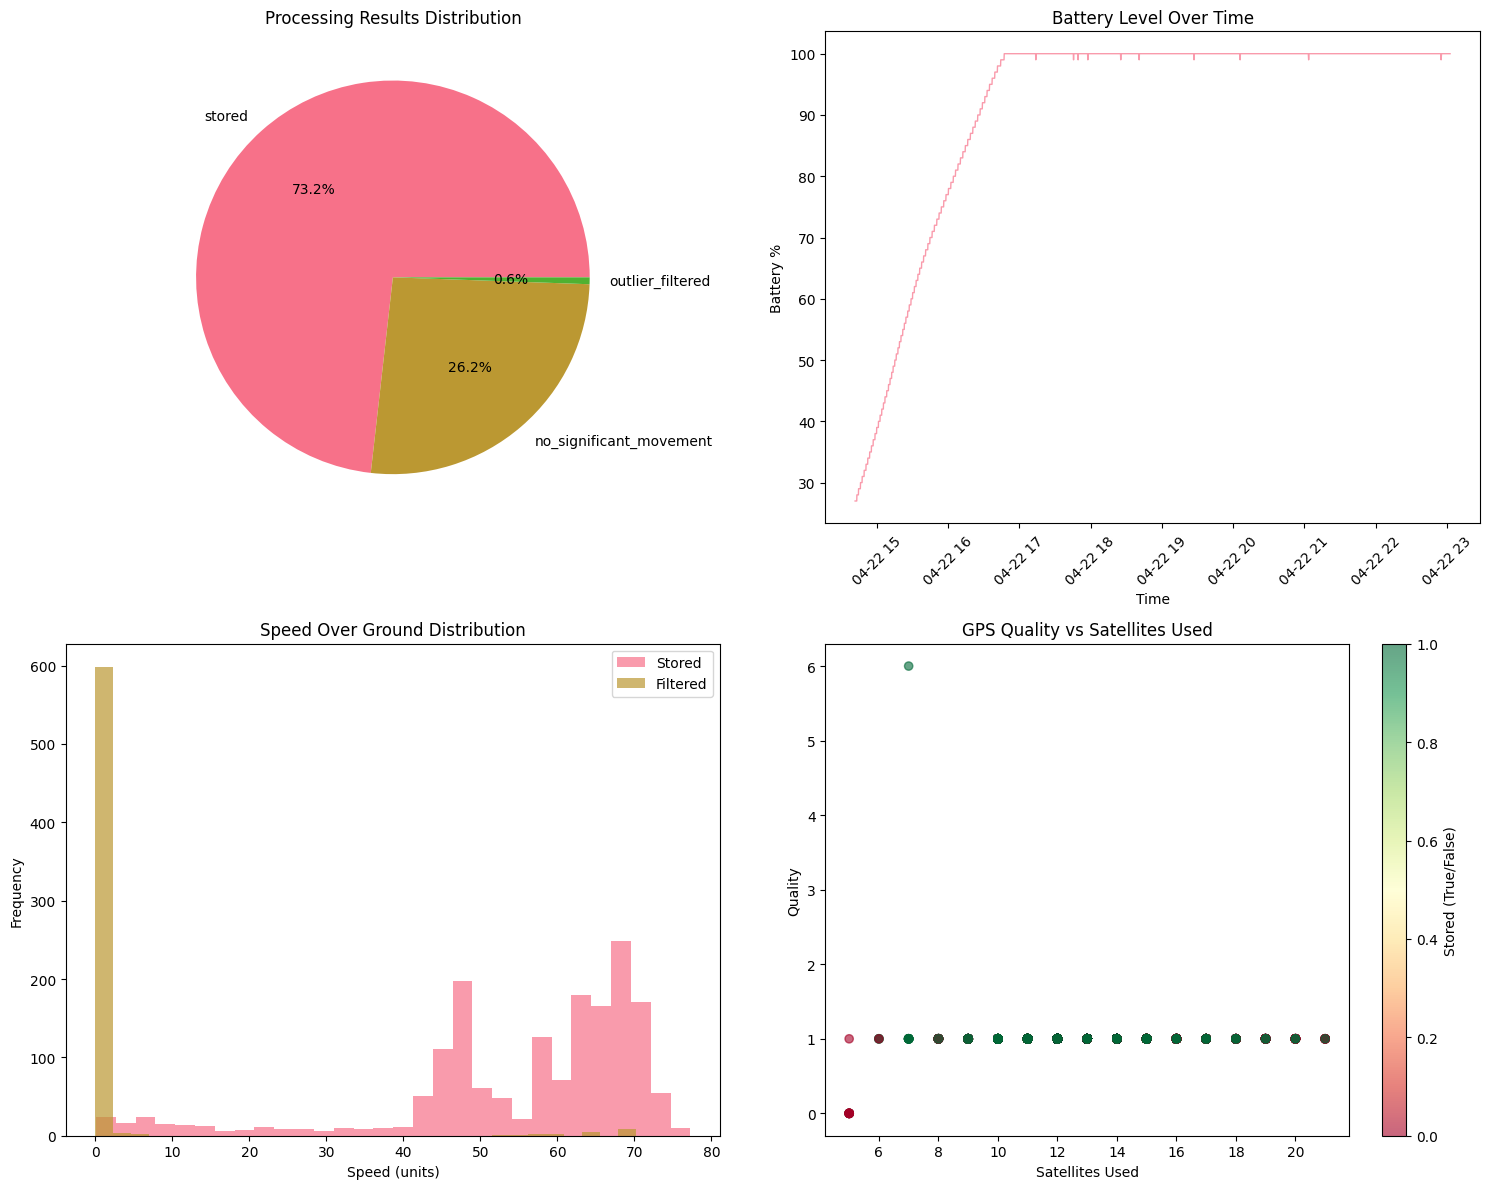

In [43]:
# Create overview visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Processing results pie chart
processing_counts = df['processing_result'].value_counts()
axes[0, 0].pie(processing_counts.values, labels=processing_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Processing Results Distribution')

# Battery level over time
axes[0, 1].plot(df['time'], df['battery'], alpha=0.7, linewidth=1)
axes[0, 1].set_title('Battery Level Over Time')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Battery %')
axes[0, 1].tick_params(axis='x', rotation=45)

# Speed over ground distribution
stored_data = df[df['stored'] == True]
filtered_data = df[df['stored'] == False]

axes[1, 0].hist(stored_data['sog'], alpha=0.7, label='Stored', bins=30)
axes[1, 0].hist(filtered_data['sog'], alpha=0.7, label='Filtered', bins=30)
axes[1, 0].set_title('Speed Over Ground Distribution')
axes[1, 0].set_xlabel('Speed (units)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Quality vs satellites
scatter = axes[1, 1].scatter(df['satellites_used'], df['quality'], 
                           c=df['stored'], alpha=0.6, cmap='RdYlGn')
axes[1, 1].set_title('GPS Quality vs Satellites Used')
axes[1, 1].set_xlabel('Satellites Used')
axes[1, 1].set_ylabel('Quality')
plt.colorbar(scatter, ax=axes[1, 1], label='Stored (True/False)')

plt.tight_layout()
plt.show()

In [44]:
# Interactive map showing GPS trajectory
fig = go.Figure()

# Plot stored points
stored_points = df[df['stored'] == True]
if len(stored_points) > 0:
    fig.add_trace(go.Scattermapbox(
        lat=stored_points['lat'],
        lon=stored_points['lon'],
        mode='markers+lines',
        marker=dict(size=6, color='green', opacity=0.8),
        line=dict(width=2, color='green'),
        name='Stored Points',
        hovertemplate='<b>Stored Point</b><br>' +
                      'Lat: %{lat}<br>' +
                      'Lon: %{lon}<br>' +
                      '<extra></extra>'
    ))

# Plot filtered points
filtered_points = df[df['stored'] == False]
if len(filtered_points) > 0:
    fig.add_trace(go.Scattermapbox(
        lat=filtered_points['lat'],
        lon=filtered_points['lon'],
        mode='markers',
        marker=dict(size=4, color='red', opacity=0.6),
        name='Filtered Points',
        hovertemplate='<b>Filtered Point</b><br>' +
                      'Lat: %{lat}<br>' +
                      'Lon: %{lon}<br>' +
                      'Reason: %{customdata}<br>' +
                      '<extra></extra>',
        customdata=filtered_points['reason']
    ))

# Calculate map center
center_lat = df['lat'].mean()
center_lon = df['lon'].mean()

fig.update_layout(
    mapbox=dict(
        style='open-street-map',
        center=dict(lat=center_lat, lon=center_lon),
        zoom=12
    ),
    title='GPS Trajectory: Stored vs Filtered Points',
    height=600,
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

In [45]:
# Time series analysis
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    subplot_titles=['Processing Results Over Time', 'Distance from Last Point', 
                   'Speed Over Ground', 'GPS Quality Metrics'],
    vertical_spacing=0.08
)

# Processing results over time
colors = {'stored': 'green', 'outlier_filtered': 'red'}
for result, color in colors.items():
    mask = df['processing_result'] == result
    fig.add_trace(
        go.Scatter(
            x=df[mask]['time'],
            y=[result] * sum(mask),
            mode='markers',
            marker=dict(color=color, size=4, opacity=0.7),
            name=result.title().replace('_', ' '),
            showlegend=True
        ),
        row=1, col=1
    )

# Distance from last point
valid_distances = df.dropna(subset=['distance_from_last'])
fig.add_trace(
    go.Scatter(
        x=valid_distances['time'],
        y=valid_distances['distance_from_last'],
        mode='lines+markers',
        name='Distance from Last',
        line=dict(color='blue'),
        showlegend=False
    ),
    row=2, col=1
)

# Speed over ground
fig.add_trace(
    go.Scatter(
        x=df['time'],
        y=df['sog'],
        mode='lines',
        name='Speed Over Ground',
        line=dict(color='orange'),
        showlegend=False
    ),
    row=3, col=1
)

# GPS Quality and satellites
fig.add_trace(
    go.Scatter(
        x=df['time'],
        y=df['quality'],
        mode='lines',
        name='GPS Quality',
        line=dict(color='purple'),
        yaxis='y4'
    ),
    row=4, col=1
)

# Add secondary y-axis for satellites
fig.add_trace(
    go.Scatter(
        x=df['time'],
        y=df['satellites_used'],
        mode='lines',
        name='Satellites Used',
        line=dict(color='brown', dash='dash'),
        yaxis='y5'
    ),
    row=4, col=1
)

# Update layout
fig.update_layout(
    height=800,
    title='Time Series Analysis of GPS Processing Results',
    xaxis4_title='Time'
)

# Update y-axis labels
fig.update_yaxes(title_text="Result", row=1, col=1)
fig.update_yaxes(title_text="Distance (m)", row=2, col=1)
fig.update_yaxes(title_text="Speed", row=3, col=1)
fig.update_yaxes(title_text="Quality", row=4, col=1)

fig.show()

In [46]:
# Statistical analysis of filtering criteria
print("=== FILTERING ANALYSIS ===")
print("\nDistance statistics for filtered points:")
filtered_with_distance = df[(df['stored'] == False) & (df['distance_from_last'].notna())]
if len(filtered_with_distance) > 0:
    print(filtered_with_distance['distance_from_last'].describe())

print("\nQuality comparison:")
quality_comparison = df.groupby('stored')['quality'].agg(['mean', 'median', 'std']).round(2)
print(quality_comparison)

print("\nSatellites comparison:")
satellites_comparison = df.groupby('stored')['satellites_used'].agg(['mean', 'median', 'std']).round(2)
print(satellites_comparison)

print("\nSpeed comparison:")
speed_comparison = df.groupby('stored')['sog'].agg(['mean', 'median', 'std']).round(2)
print(speed_comparison)

=== FILTERING ANALYSIS ===

Distance statistics for filtered points:
count     624.000000
mean       31.557528
std       246.098984
min         0.000000
25%         2.135939
50%         3.692460
75%         3.692460
max      3819.479682
Name: distance_from_last, dtype: float64

Quality comparison:
        mean  median   std
stored                    
False   0.99     1.0  0.11
True    1.00     1.0  0.13

Satellites comparison:
         mean  median   std
stored                     
False   15.02    15.0  3.40
True    12.73    13.0  2.24

Speed comparison:
         mean  median    std
stored                      
False    2.50    0.34  11.27
True    55.25   61.08  16.80


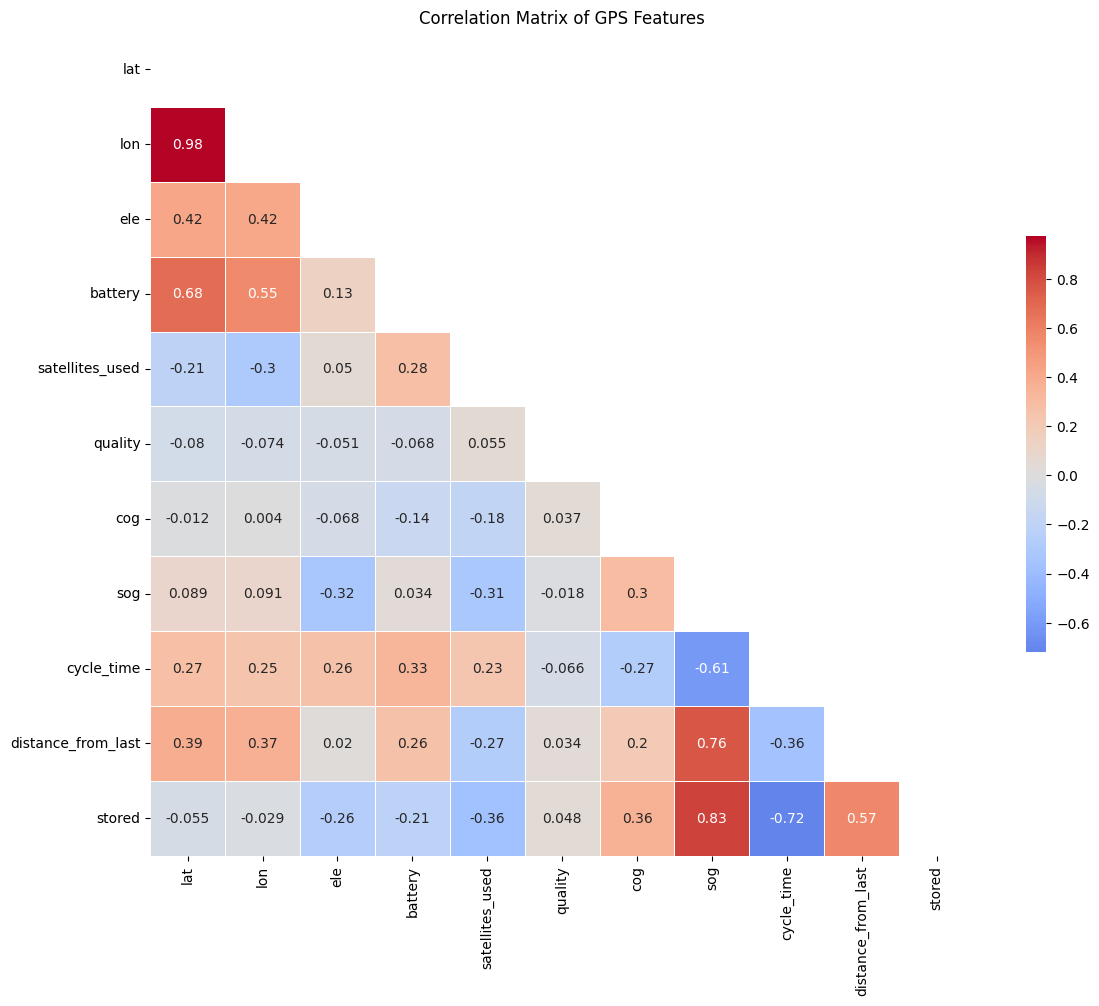


Correlations with 'stored' status:
sog                   0.833177
cycle_time            0.720199
distance_from_last    0.567646
satellites_used       0.364415
cog                   0.362181
ele                   0.256674
battery               0.214388
lat                   0.055019
quality               0.047573
lon                   0.028519
Name: stored, dtype: float64


In [47]:
# Correlation analysis and feature importance
# Create a correlation matrix for numerical features
numerical_cols = ['lat', 'lon', 'ele', 'battery', 'satellites_used', 'quality', 
                 'cog', 'sog', 'cycle_time', 'distance_from_last']
correlation_data = df[numerical_cols + ['stored']].copy()
correlation_data['stored'] = correlation_data['stored'].astype(int)

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of GPS Features')
plt.tight_layout()
plt.show()

# Show correlations with the 'stored' variable
print("\nCorrelations with 'stored' status:")
stored_correlations = corr_matrix['stored'].drop('stored').abs().sort_values(ascending=False)
print(stored_correlations)

<Figure size 1500x1000 with 0 Axes>

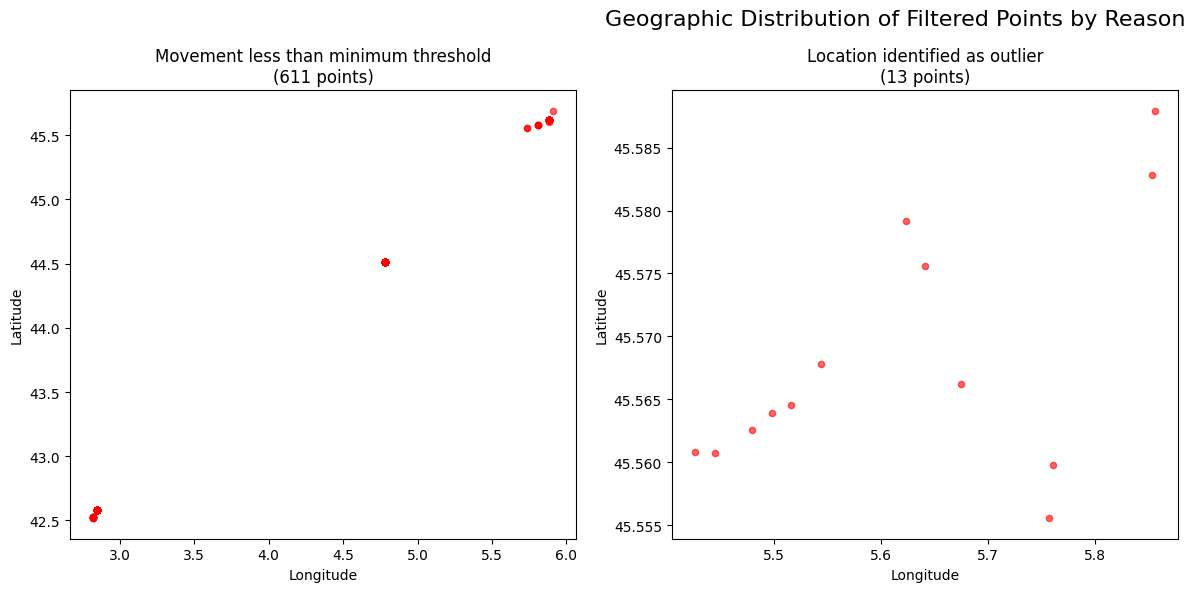

In [48]:
# Detailed analysis by filtering reason
plt.figure(figsize=(15, 10))

# Create subplots for each filtering reason
filtering_reasons = df[df['stored'] == False]['reason'].unique()
n_reasons = len(filtering_reasons)

if n_reasons > 0:
    rows = (n_reasons + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, reason in enumerate(filtering_reasons):
        row = i // 3
        col = i % 3
        
        reason_data = df[df['reason'] == reason]
        
        if len(reason_data) > 0:
            axes[row, col].scatter(reason_data['lon'], reason_data['lat'], 
                                 alpha=0.6, s=20, c='red')
            axes[row, col].set_title(f'{reason}\n({len(reason_data)} points)')
            axes[row, col].set_xlabel('Longitude')
            axes[row, col].set_ylabel('Latitude')
    
    # Hide empty subplots
    for i in range(n_reasons, rows * 3):
        row = i // 3
        col = i % 3
        axes[row, col].set_visible(False)
    
    plt.suptitle('Geographic Distribution of Filtered Points by Reason', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No filtered points found in the data.")

In [49]:
# Performance metrics and summary
print("=== PROCESSING PERFORMANCE SUMMARY ===")
print(f"Total GPS points processed: {len(df)}")
print(f"Points stored: {df['stored'].sum()} ({df['stored'].mean():.2%})")
print(f"Points filtered: {(~df['stored']).sum()} ({(~df['stored']).mean():.2%})")

if df['distance_from_last'].notna().any():
    print(f"\nDistance metrics:")
    print(f"Average distance between points: {df['distance_from_last'].mean():.2f}m")
    print(f"Maximum distance: {df['distance_from_last'].max():.2f}m")
    print(f"Minimum distance: {df['distance_from_last'].min():.2f}m")

print(f"\nData quality metrics:")
print(f"Average GPS quality: {df['quality'].mean():.2f}")
print(f"Average satellites used: {df['satellites_used'].mean():.1f}")
print(f"Speed range: {df['sog'].min():.1f} - {df['sog'].max():.1f}")

# Calculate processing efficiency
time_span = (df['time'].max() - df['time'].min()).total_seconds() / 3600  # hours
if time_span > 0:
    points_per_hour = len(df) / time_span
    print(f"\nProcessing rate: {points_per_hour:.1f} points per hour")
    print(f"Time span: {time_span:.2f} hours")

print("\n=== OUTLIER DETECTION EFFECTIVENESS ===")
if 'outlier_filtered' in df['processing_result'].values:
    outlier_count = (df['processing_result'] == 'outlier_filtered').sum()
    print(f"Outliers detected: {outlier_count} ({outlier_count/len(df):.2%})")
    
    # Analyze outlier characteristics
    outliers = df[df['processing_result'] == 'outlier_filtered']
    if len(outliers) > 0 and outliers['distance_from_last'].notna().any():
        print(f"Average distance for outliers: {outliers['distance_from_last'].mean():.2f}m")
        print(f"Median distance for outliers: {outliers['distance_from_last'].median():.2f}m")
else:
    print("No outliers detected in this dataset.")

=== PROCESSING PERFORMANCE SUMMARY ===
Total GPS points processed: 2329
Points stored: 1705 (73.21%)
Points filtered: 624 (26.79%)

Distance metrics:
Average distance between points: 283.62m
Maximum distance: 3971.99m
Minimum distance: 0.00m

Data quality metrics:
Average GPS quality: 1.00
Average satellites used: 13.3
Speed range: 0.0 - 77.3

Processing rate: 279.0 points per hour
Time span: 8.35 hours

=== OUTLIER DETECTION EFFECTIVENESS ===
Outliers detected: 13 (0.56%)
Average distance for outliers: 1354.54m
Median distance for outliers: 747.04m


In [50]:
# Final summary visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Processing Results Summary', 'Distance Distribution', 
                   'Quality vs Storage Decision', 'Battery Level Impact'],
    specs=[[{"type": "pie"}, {"type": "histogram"}],
           [{"type": "box"}, {"type": "scatter"}]]
)

# Pie chart of processing results
result_counts = df['processing_result'].value_counts()
fig.add_trace(
    go.Pie(labels=result_counts.index, values=result_counts.values, 
           name="Processing Results"),
    row=1, col=1
)

# Distance distribution histogram
valid_distances = df['distance_from_last'].dropna()
if len(valid_distances) > 0:
    fig.add_trace(
        go.Histogram(x=valid_distances, name="Distance Distribution", 
                    nbinsx=30, showlegend=False),
        row=1, col=2
    )

# Quality comparison box plot
for stored_status in [True, False]:
    data_subset = df[df['stored'] == stored_status]
    fig.add_trace(
        go.Box(y=data_subset['quality'], 
               name=f"{'Stored' if stored_status else 'Filtered'}",
               showlegend=False),
        row=2, col=1
    )

# Battery vs time colored by storage decision
fig.add_trace(
    go.Scatter(x=df['battery'], y=df['time'], 
              mode='markers',
              marker=dict(color=df['stored'].astype(int), 
                         colorscale='RdYlGn',
                         showscale=True,
                         colorbar=dict(title="Stored")),
              name="Battery vs Time", showlegend=False),
    row=2, col=2
)

fig.update_layout(
    height=800,
    title_text="GPS Location Processing Analysis Summary",
    showlegend=True
)

fig.show()

print("\n🎉 Analysis complete! This notebook provides a comprehensive view of the GPS location processing results.")


🎉 Analysis complete! This notebook provides a comprehensive view of the GPS location processing results.
